In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve,auc, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.preprocessing import OneHotEncoder
import matplotlib
import sklearn
#from skopt import BayesSearchCV, space
import optuna
import optuna.study
from optuna import Trial
from optuna import distributions
from optuna import integration
from optuna.study import create_study
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
import joblib
plt.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False
import operator

In [18]:
class EarlyStoppingCallback(object):
    def __init__(self, early_stopping_rounds: int, direction: str = "minimize"):
        self.early_stopping_rounds = early_stopping_rounds

        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study, trial):
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

In [19]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [20]:
청년가구 = pd.read_csv('청년가구_변수추가.csv', encoding='cp949')
청년가구.rename(columns = {'문41. 귀 가구는 공공임대주택 입주 기회를 준다면 입주할 의향이 있으십니까?':'target'}, inplace=True)

In [21]:
청년가구.columns = [
    'Cat_현재 거주 지역', 'Cat_현재 주택의 유형','Cat_현재 주택의 위치',
    '현재 주택 거주 기간(총 개월)','현재 무주택 기간(총 개월)',
    'Cat_현재 주택의 점유형태','Cat_현재 주택의 구조', '현재 주택의 면적(㎡)',
    'Cat_현재 상업시설 접근용이성', 'Cat_현재 의료시설 접근용이성',
    'Cat_현재 공공기관 접근용이성', 'Cat_현재 문화시설 접근용이성',
    'Cat_현재 도시공원 및 녹지 접근용이성', 'Cat_현재 대중교통 접근용이성',
    'Cat_현재 주차시설 이용편의성', 'Cat_현재 주변도로의 보행 안전',
    'Cat_현재 교육환경', 'Cat_현재 치안 및 범죄 등 방범 상태',
    'Cat_현재 자동차 경적/집주변의 소음 정도', 'Cat_현재 청소/쓰레기 처리상태',
    'Cat_현재 대기오염 정도', 'Cat_현재 주택에 대한 전반적인 만족도',
    '총 이사 횟수', 'Cat_이사 예상 기간','Cat_이사 계획 첫 번째 이유',
    'Cat_이사 계획 중인 거주 지역', 'Cat_이사 계획 중인 주택의 유형', 'Cat_이사 계획 중인 주택의 점유형태',
    'Cat_주택 보유 의식', 'Cat_현재 가장 필요한 주거지원 1순위',
    '가구주 나이','Cat_가구주 성별','Cat_가구주 주민등록상 등재 여부','Cat_가구주 동거 여부','Cat_가구주 장애 여부',
    '총 가구원 수','Cat_기초생활보장 수급가구 여부','Cat_소득 계층',
    '소득 대비 주택 임대료의 비율', '소득 중 근로/사업소득의 비중(월평균)',
    '소득 중 재산소득의 비중(월평균)', '소득 중 사회보험 수혜금의 비중(월평균)',
    '소득 중 정부 보조금의 비중(월평균)', '소득 중 사적이전소득의 비중(월평균)', 
    '소득 대비 생활비의 비율', '소득 대비 주거관리비의 비율',
    '자산 중 부동산 자산의 비중', '자산 중 금융자산의 비중', '자산 중 기타자산의 비중',
    '부채 중 금융기관 대출금의 비중', '부채 중 비금융기관 대출금의 비중', '부채 중 임대 보증금의 비중',
    '중기부채부담지표', '장기부채부담지표', 'Cat_가구주 최종 학력', 'Cat_가구주 종사상 지위',
    'target'    
]

In [22]:
cat = 청년가구.select_dtypes(include = 'object')

In [23]:
num = 청년가구.select_dtypes(exclude = 'object')
num_청년 = num.drop('target',axis=1)

In [24]:
scaler=RobustScaler()
scaler.fit(num_청년)
num_scaled_청년=scaler.transform(num_청년)
num_df_scaled_청년=pd.DataFrame(data=num_scaled_청년, columns=num_청년.columns)

In [25]:
target = 청년가구.target

In [26]:
enc = OneHotEncoder()
enc.fit(cat)

X_cat = enc.transform(cat).toarray()
new_feature_names = enc.get_feature_names_out(cat.columns)
cat2 = pd.DataFrame(X_cat, columns= new_feature_names)

In [27]:
comp =pd.concat([num_df_scaled_청년, target,cat2],axis=1)

In [28]:
X =comp.drop('target', axis = 1)
y=comp.target
X.shape

(8444, 213)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state = 0)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [15]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])

        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [16]:
print(study.best_trial.params)

{'n_estimators': 127, 'learning_rate': 0.06999999999999999, 'max_depth': 7, 'max_leaves': 826, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 1, 'reg_lambda': 4, 'booster': 'gbtree', 'objective': 'binary:logistic'}


In [17]:
optuna_auc = study.best_trial.value
print(optuna_auc)

0.7892349033629601


In [18]:
xgb_optuna_0 = XGBClassifier(**study.best_trial.params, random_state = 0)

In [19]:
xgb_optuna_0.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06999999999999999,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=826,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=127, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [20]:
xgb_optuna_0_proba = xgb_optuna_0.predict_proba(X_test)[:, 1]
auc_0 = roc_auc_score(y_test, xgb_optuna_0_proba)
print(auc_0)

0.7798956071299312


In [21]:
X_train = X_train.values
y_train = y_train.values

In [22]:
from sklearn.utils import resample
from numpy.random import RandomState

In [23]:
from scipy.stats import shapiro

In [24]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [70]:
auc_bootstrap = []
def bootstrap_auc(clf, X_train, y_train, X_test, y_test, nsamples=10000):
    for b in range(nsamples):
        idx = np.random.randint(X_train.shape[0], size=X_train.shape[0])
        clf.fit(X_train[idx], y_train[idx])
        pred = clf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test.ravel(), pred.ravel())
        auc_bootstrap.append(roc_auc)
    return np.percentile(auc_bootstrap, (2.5, 97.5))

In [45]:
np.random.seed(999999)
bootstrap_auc(xgb_optuna_0, X_train, y_train, X_test, y_test, nsamples=1000)

array([0.76307601, 0.77916027])

In [46]:
np.random.seed(999999)
bootstrap_auc(xgb_optuna_0, X_train, y_train, X_test, y_test, nsamples=1000)

array([0.76307601, 0.77916027])

In [47]:
np.mean(auc_bootstrap)

0.7710727038940915

In [48]:
shapiro(auc_bootstrap)

ShapiroResult(statistic=0.9961628913879395, pvalue=5.796792538603768e-05)

In [49]:
t_0 = auc_bootstrap
print(t_0)

[0.7722258980275064, 0.7741811436844009, 0.7743974506876584, 0.7686617806731814, 0.7704671665761853, 0.7707131627759682, 0.7751057500904814, 0.776339972403185, 0.7755581568946797, 0.7699066062703582, 0.7698889341295693, 0.7729822656532754, 0.7645561889250814, 0.7723672751538182, 0.7725545998461816, 0.7698634862468332, 0.7701547231270358, 0.7673186979732174, 0.7640387486427795, 0.7680595141150923, 0.77407652461093, 0.77599783975751, 0.7711500180962723, 0.7751043363192183, 0.7714242897213175, 0.768893639160333, 0.7750732333514296, 0.7697221091205213, 0.7701193788454578, 0.7766425194534925, 0.7690915671371699, 0.7720138323380383, 0.7730161961635903, 0.77021551529135, 0.7756104664314152, 0.7715995973579443, 0.7680354800036192, 0.7660420625226204, 0.7738602176076728, 0.759878019815418, 0.7707704205121245, 0.7685387825732899, 0.7710029858849077, 0.7724422050307638, 0.7717833876221498, 0.7763866268548678, 0.7711698108939558, 0.7714214621787912, 0.76968535106768, 0.770816368078176, 0.767728691

In [50]:
import matplotlib.pyplot as plt

(array([ 12.,  28.,  74., 188., 452., 540., 382., 222.,  78.,  24.]),
 array([0.75748168, 0.7599702 , 0.76245872, 0.76494724, 0.76743576, 0.76992428, 0.7724128 , 0.77490132, 0.77738984, 0.77987836, 0.78236688]),
 <BarContainer object of 10 artists>)

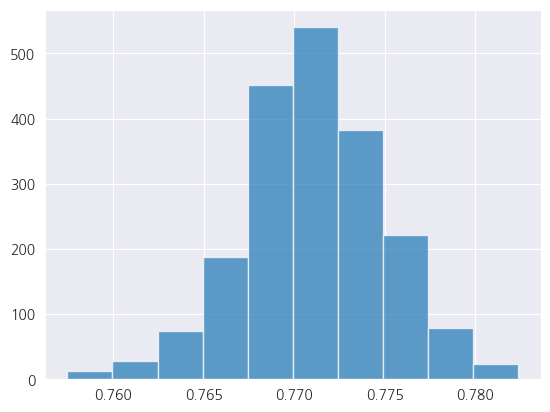

In [51]:
plt.hist(t_0, alpha=0.7)

auc_bootstrap = []
for _ in range(2000):

    X_test_re, y_test_re = resample(X_test, y_test, replace = True, random_state=0)

    proba_0 = xgb_optuna_0.predict_proba(X_test_re)[:,1]

    auc_bootstrap.append(roc_auc_score(y_test_re,proba_0))

In [30]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

#### 1. 'Cat_가구주 장애 여부' 제거

In [29]:
column_to_drop = 'Cat_가구주 장애 여부'

In [30]:
if not column_to_drop.startswith('Cat_'):
    comp_1 = comp.drop(column_to_drop, axis=1)
    X_1 = comp_1.drop('target', axis=1)
    y_1 = comp_1['target']
else:
    comp_1 = comp.drop(comp.filter(regex='^' + column_to_drop).columns, axis=1)
    X_1 = comp_1.drop('target', axis=1)
    y_1 = comp_1['target']

print(X_1.shape)

(8444, 211)


In [33]:
import decimal
context = decimal.getcontext()

context.rounding = decimal.ROUND_HALF_UP

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, shuffle=True, stratify=y_1, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [35]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])

        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [36]:
print(study.best_trial.params)

{'n_estimators': 127, 'learning_rate': 0.06999999999999999, 'max_depth': 7, 'max_leaves': 826, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 1, 'reg_lambda': 4, 'booster': 'gbtree', 'objective': 'binary:logistic'}


In [37]:
optuna_auc = study.best_trial.value
print(optuna_auc)

0.7892349033629601


In [38]:
xgb_optuna_1 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06999999999999999,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=826,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=127, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [39]:
xgb_optuna_1_proba = xgb_optuna_1.predict_proba(X_test)[:, 1]
auc_1 = roc_auc_score(y_test, xgb_optuna_1_proba)
print(auc_1)

0.7798956071299312


In [40]:
def permutation_test_between_clfs(y_test, pred_proba_1, pred_proba_2, nsamples=2000):
    auc_differences = []
    auc1 = roc_auc_score(y_test.ravel(), pred_proba_1.ravel())
    auc2 = roc_auc_score(y_test.ravel(), pred_proba_2.ravel())
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1.ravel()))
        p1 = np.where(mask, pred_proba_1.ravel(), pred_proba_2.ravel())
        p2 = np.where(mask, pred_proba_2.ravel(), pred_proba_1.ravel())
        auc1 = roc_auc_score(y_test.ravel(), p1)
        auc2 = roc_auc_score(y_test.ravel(), p2)
        auc_differences.append(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

In [41]:
X_train = X_train.values
y_train = y_train.values

In [42]:
auc_bootstrap = []
auc_bootstrap

[]

In [43]:
rs = RandomState(seed = 1)
bootstrap_auc(xgb_optuna_1, X_train, y_train, X_test, y_test, nsamples=1000)

KeyboardInterrupt: 

In [ ]:
decimal.Decimal('0.76368714').quantize(decimal.Decimal('1.000')), decimal.Decimal('0.77841037').quantize(decimal.Decimal('1.000'))

In [ ]:
shapiro(auc_bootstrap)

In [ ]:
np.mean(auc_bootstrap)

In [ ]:
decimal.Decimal('0.7709262407256606').quantize(decimal.Decimal('1.000'))

In [ ]:
t_1 = auc_bootstrap
print(t_1)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

#### 2. Cat_가구주 동거 여부	제거

In [31]:
column_to_drop_1 = 'Cat_가구주 동거 여부'

In [32]:
if not column_to_drop_1.startswith('Cat_'):
    comp_2 = comp_1.drop(column_to_drop_1, axis=1)
    X_2 = comp_2.drop('target', axis=1)
    y_2 = comp_2['target']
else:
    comp_2 = comp_1.drop(comp_1.filter(regex='^' + column_to_drop_1).columns, axis=1)
    X_2 = comp_2.drop('target', axis=1)
    y_2 = comp_2['target']

print(X_2.shape)

(8444, 210)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, shuffle=True, stratify=y_2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_2 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_2.fit(X_train, y_train)

In [ ]:
xgb_optuna_2_proba = xgb_optuna_2.predict_proba(X_test)[:, 1]
auc_2 = roc_auc_score(y_test, xgb_optuna_2_proba)
print(decimal.Decimal(auc_2).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 2)
bootstrap_auc(xgb_optuna_2, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
decimal.Decimal('0.763322').quantize(decimal.Decimal('1.000')), decimal.Decimal('0.77834399').quantize(decimal.Decimal('1.000'))

In [ ]:
shapiro(auc_bootstrap)

In [ ]:
np.mean(auc_bootstrap)

In [ ]:
decimal.Decimal('0.7709589705907302').quantize(decimal.Decimal('1.000'))

In [ ]:
t_2 = auc_bootstrap
print(t_2)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

#### 3. 부채 중 임대 보증금의 비중	 제거

In [33]:
column_to_drop_2 = '부채 중 임대 보증금의 비중'

In [34]:
if not column_to_drop_2.startswith('Cat_'):
    comp_3 = comp_2.drop(column_to_drop_2, axis=1)
    X_3 = comp_3.drop('target', axis=1)
    y_3 = comp_3['target']
else:
    comp_3 = comp_2.drop(comp_2.filter(regex='^' + column_to_drop_2).columns, axis=1)
    X_3 = comp_3.drop('target', axis=1)
    y_3 = comp_3['target']

print(X_3.shape)

(8444, 209)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.2, shuffle=True, stratify=y_3, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_3 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_3.fit(X_train, y_train)

In [ ]:
xgb_optuna_3_proba = xgb_optuna_3.predict_proba(X_test)[:, 1]
auc_3 = roc_auc_score(y_test, xgb_optuna_3_proba)
print(decimal.Decimal(auc_3).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 3)
bootstrap_auc(xgb_optuna_3, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
decimal.Decimal('0.76336265').quantize(decimal.Decimal('1.000')), decimal.Decimal('0.7781291').quantize(decimal.Decimal('1.000'))

In [ ]:
shapiro(auc_bootstrap)

In [ ]:
decimal.Decimal('0.7709458006045286').quantize(decimal.Decimal('1.000'))

In [ ]:
t_3 = auc_bootstrap
print(t_3)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [35]:
### 4. 소득 중 재산소득의 비중(월평균) 
column_to_drop_3 = '소득 중 재산소득의 비중(월평균)'

In [36]:
if not column_to_drop_3.startswith('Cat_'):
    comp_4 = comp_3.drop(column_to_drop_3, axis=1)
    X_4 = comp_4.drop('target', axis=1)
    y_4 = comp_4['target']
else:
    comp_4 = comp_3.drop(comp_3.filter(regex='^' + column_to_drop_3).columns, axis=1)
    X_4 = comp_4.drop('target', axis=1)
    y_4 = comp_4['target']

print(X_4.shape)

(8444, 208)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.2, shuffle=True, stratify=y_4, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_4 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_4.fit(X_train, y_train)

In [ ]:
xgb_optuna_4_proba = xgb_optuna_4.predict_proba(X_test)[:, 1]
auc_4 = roc_auc_score(y_test, xgb_optuna_4_proba)
print(decimal.Decimal(auc_4).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 4)
bootstrap_auc(xgb_optuna_4, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
decimal.Decimal('0.76275603').quantize(decimal.Decimal('1.000')), decimal.Decimal('0.77823223').quantize(decimal.Decimal('1.000'))

In [ ]:
shapiro(auc_bootstrap)

In [ ]:
np.mean(auc_bootstrap)

In [ ]:
decimal.Decimal('0.770843661639296').quantize(decimal.Decimal('1.000'))

In [ ]:
t_4 = auc_bootstrap
print(t_4)

In [37]:
## 5.소득 중 사회보험 수혜금의 비중(월평균)
column_to_drop_4 = '소득 중 사회보험 수혜금의 비중(월평균)'

In [38]:
if not column_to_drop_4.startswith('Cat_'):
    comp_5 = comp_4.drop(column_to_drop_4, axis=1)
    X_5 = comp_5.drop('target', axis=1)
    y_5 = comp_5['target']
else:
    comp_5 = comp_4.drop(comp_4.filter(regex='^' + column_to_drop_4).columns, axis=1)
    X_5 = comp_5.drop('target', axis=1)
    y_5 = comp_5['target']

print(X_5.shape)

(8444, 207)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_5, y_5, test_size=0.2, shuffle=True, stratify=y_5, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_5 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_5.fit(X_train, y_train)

In [ ]:
xgb_optuna_5_proba = xgb_optuna_5.predict_proba(X_test)[:, 1]
auc_5 = roc_auc_score(y_test, xgb_optuna_5_proba)
print(decimal.Decimal(auc_5).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 5)
bootstrap_auc(xgb_optuna_5, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
decimal.Decimal('0.76356167').quantize(decimal.Decimal('1.000')), decimal.Decimal('0.77847056').quantize(decimal.Decimal('1.000'))

In [ ]:
shapiro(auc_bootstrap)

In [ ]:
np.mean(auc_bootstrap)

In [ ]:
decimal.Decimal('0.7709745036955981').quantize(decimal.Decimal('1.000'))

In [ ]:
t_5 = auc_bootstrap
print(t_5)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [39]:
## 6.부채 중 비금융기관 대출금의 비중	
column_to_drop_5 = '부채 중 비금융기관 대출금의 비중'

In [40]:
if not column_to_drop_5.startswith('Cat_'):
    comp_6 = comp_5.drop(column_to_drop_5, axis=1)
    X_6 = comp_6.drop('target', axis=1)
    y_6 = comp_6['target']
else:
    comp_6 = comp_5.drop(comp_5.filter(regex='^' + column_to_drop_5).columns, axis=1)
    X_6 = comp_6.drop('target', axis=1)
    y_6 = comp_6['target']

print(X_6.shape)

(8444, 206)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_6, y_6, test_size=0.2, shuffle=True, stratify=y_6, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_6 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_6.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_6 = xgb_optuna_6.predict_proba(X_test)[:, 1]
auc_6 = roc_auc_score(y_test, xgb_optuna_proba_6)
print(decimal.Decimal(auc_6).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 6)
bootstrap_auc(xgb_optuna_6, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
decimal.Decimal('0.76356381').quantize(decimal.Decimal('1.000')), decimal.Decimal('0.77801815').quantize(decimal.Decimal('1.000'))

In [ ]:
shapiro(auc_bootstrap)

In [ ]:
np.mean(auc_bootstrap)

In [ ]:
decimal.Decimal('0.770935725363622').quantize(decimal.Decimal('1.000'))

In [ ]:
t_6 = auc_bootstrap
print(t_6)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [41]:
## 7 . 자산 중 부동산 자산의 비중	
column_to_drop_6 = '자산 중 부동산 자산의 비중'

In [42]:
if not column_to_drop_6.startswith('Cat_'):
    comp_7 = comp_6.drop(column_to_drop_6, axis=1)
    X_7 = comp_7.drop('target', axis=1)
    y_7 = comp_7['target']
else:
    comp_7 = comp_6.drop(comp_6.filter(regex='^' + column_to_drop_6).columns, axis=1)
    X_7 = comp_7.drop('target', axis=1)
    y_7 = comp_7['target']

print(X_7.shape)

(8444, 205)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_7, y_7, test_size=0.2, shuffle=True, stratify=y_7, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200)

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_7 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_7.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_7 = xgb_optuna_7.predict_proba(X_test)[:, 1]
auc_7 = roc_auc_score(y_test, xgb_optuna_proba_7)
print(decimal.Decimal(auc_7).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 7)
bootstrap_auc(xgb_optuna_7, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
decimal.Decimal('0.7634543').quantize(decimal.Decimal('1.000')), decimal.Decimal('0.77866898').quantize(decimal.Decimal('1.000'))

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_7 = auc_bootstrap
print(t_7)

In [ ]:
np.mean(t_7)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [43]:
## 8 .Cat_현재 주택의 위치	
column_to_drop_7 = 'Cat_현재 주택의 위치'

In [44]:
if not column_to_drop_7.startswith('Cat_'):
    comp_8 = comp_7.drop(column_to_drop_7, axis=1)
    X_8 = comp_8.drop('target', axis=1)
    y_8 = comp_8['target']
else:
    comp_8 = comp_7.drop(comp_7.filter(regex='^' + column_to_drop_7).columns, axis=1)
    X_8 = comp_8.drop('target', axis=1)
    y_8 = comp_8['target']

print(X_8.shape)

(8444, 201)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_8, y_8, test_size=0.2, shuffle=True, stratify=y_8, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_8 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_8.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_8 = xgb_optuna_8.predict_proba(X_test)[:, 1]
auc_8 = roc_auc_score(y_test, xgb_optuna_proba_8)
print(decimal.Decimal(auc_8).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 8)
bootstrap_auc(xgb_optuna_8, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
decimal.Decimal('0.76345281').quantize(decimal.Decimal('1.000')), decimal.Decimal('0.77841981').quantize(decimal.Decimal('1.000'))

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_8 = auc_bootstrap
print(t_8)

In [ ]:
np.mean(t_8)

In [ ]:
decimal.Decimal('0.76356167').quantize(decimal.Decimal('1.000'))

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [45]:
#9.Cat_이사 계획 첫 번째 이유
column_to_drop_8 = 'Cat_이사 계획 첫 번째 이유'

In [46]:
if not column_to_drop_8.startswith('Cat_'):
    comp_9 = comp_8.drop(column_to_drop_8, axis=1)
    X_9 = comp_9.drop('target', axis=1)
    y_9 = comp_9['target']
else:
    comp_9 = comp_8.drop(comp_8.filter(regex='^' + column_to_drop_8).columns, axis=1)
    X_9 = comp_9.drop('target', axis=1)
    y_9 = comp_9['target']

print(X_9.shape)

(8444, 188)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_9, y_9, test_size=0.2, shuffle=True, stratify=y_9, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_9 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_9.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_9 = xgb_optuna_9.predict_proba(X_test)[:, 1]
auc_9 = roc_auc_score(y_test, xgb_optuna_proba_9)
print(decimal.Decimal(auc_9).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 9)
bootstrap_auc(xgb_optuna_9, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_9 = auc_bootstrap
print(t_9)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [47]:
# 10.Cat_이사 예상 기간
column_to_drop_9 = 'Cat_이사 예상 기간'

In [48]:
if not column_to_drop_9.startswith('Cat_'):
    comp_10 = comp_9.drop(column_to_drop_9, axis=1)
    X_10 = comp_10.drop('target', axis=1)
    y_10 = comp_10['target']
else:
    comp_10 = comp_9.drop(comp_9.filter(regex='^' + column_to_drop_9).columns, axis=1)
    X_10 = comp_10.drop('target', axis=1)
    y_10 = comp_10['target']

print(X_10.shape)

(8444, 184)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_10, y_10, test_size=0.2, shuffle=True, stratify=y_10, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_10 = XGBClassifier(**study.best_trial.params, random_state=0)
xgb_optuna_10.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_10 = xgb_optuna_10.predict_proba(X_test)[:, 1]
auc_10 = roc_auc_score(y_test, xgb_optuna_proba_10)
print(decimal.Decimal(auc_10).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 10)
bootstrap_auc(xgb_optuna_10, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_10 = auc_bootstrap
print(t_10)

In [ ]:
from scipy.stats import bartlett

bartlett(t_9, t_10)

In [ ]:
import pingouin as pg
ca = pg.ttest(t_9, t_10, paired=False)
print(ca)

In [ ]:
import pingouin as pg
ca = pg.ttest(t_7, t_10, paired=False)
print(ca)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [49]:
# 11.Cat_기초생활보장 수급가구 여부	
column_to_drop_10 = 'Cat_기초생활보장 수급가구 여부'

In [50]:
if not column_to_drop_10.startswith('Cat_'):
    comp_11 = comp_10.drop(column_to_drop_10, axis=1)
    X_11 = comp_11.drop('target', axis=1)
    y_11 = comp_11['target']
else:
    comp_11 = comp_10.drop(comp_10.filter(regex='^' + column_to_drop_10).columns, axis=1)
    X_11 = comp_11.drop('target', axis=1)
    y_11 = comp_11['target']

print(X_11.shape)

(8444, 182)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_11, y_11, test_size=0.2, shuffle=True, stratify=y_11, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_11 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_11.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_11 = xgb_optuna_11.predict_proba(X_test)[:, 1]
auc_11 = roc_auc_score(y_test, xgb_optuna_proba_11)
print(decimal.Decimal(auc_11).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 11)
bootstrap_auc(xgb_optuna_11, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_11 = auc_bootstrap
print(t_11)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [51]:
# 12
column_to_drop_11 = 'Cat_현재 주택의 구조'

In [52]:
if not column_to_drop_11.startswith('Cat_'):
    comp_12 = comp_11.drop(column_to_drop_11, axis=1)
    X_12 = comp_12.drop('target', axis=1)
    y_12 = comp_12['target']
else:
    comp_12 = comp_11.drop(comp_11.filter(regex='^' + column_to_drop_11).columns, axis=1)
    X_12 = comp_12.drop('target', axis=1)
    y_12 = comp_12['target']

print(X_12.shape)

(8444, 180)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_12, y_12, test_size=0.2, shuffle=True, stratify=y_12, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_12 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_12.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_12 = xgb_optuna_12.predict_proba(X_test)[:, 1]
auc_12 = roc_auc_score(y_test, xgb_optuna_proba_12)
print(decimal.Decimal(auc_12).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 12)
bootstrap_auc(xgb_optuna_12, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap),np.mean(auc_bootstrap)

In [ ]:
t_12 = auc_bootstrap
print(t_12)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [53]:
# 13.
column_to_drop_12 = 'Cat_가구주 주민등록상 등재 여부'

In [54]:
if not column_to_drop_12.startswith('Cat_'):
    comp_13 = comp_12.drop(column_to_drop_12, axis=1)
    X_13 = comp_13.drop('target', axis=1)
    y_13 = comp_13['target']
else:
    comp_13 = comp_12.drop(comp_12.filter(regex='^' + column_to_drop_12).columns, axis=1)
    X_13 = comp_13.drop('target', axis=1)
    y_13 = comp_13['target']

print(X_13.shape)

(8444, 178)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_13, y_13, test_size=0.2, shuffle=True, stratify=y_13, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_13 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_13.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_13 = xgb_optuna_13.predict_proba(X_test)[:, 1]
auc_13 = roc_auc_score(y_test, xgb_optuna_proba_13)
print(decimal.Decimal(auc_13).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 13)
bootstrap_auc(xgb_optuna_13, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap),np.mean(auc_bootstrap)

In [ ]:
t_13 = auc_bootstrap
print(t_13)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [55]:
#14.
column_to_drop_13 = 'Cat_가구주 성별'

In [56]:
if not column_to_drop_13.startswith('Cat_'):
    comp_14 = comp_13.drop(column_to_drop_13, axis=1)
    X_14 = comp_14.drop('target', axis=1)
    y_14 = comp_14['target']
else:
    comp_14 = comp_13.drop(comp_13.filter(regex='^' + column_to_drop_13).columns, axis=1)
    X_14 = comp_14.drop('target', axis=1)
    y_14 = comp_14['target']

print(X_14.shape)

(8444, 176)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_14, y_14, test_size=0.2, shuffle=True, stratify=y_14, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_14 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_14.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_14 = xgb_optuna_14.predict_proba(X_test)[:, 1]
auc_14 = roc_auc_score(y_test, xgb_optuna_proba_14)
print(decimal.Decimal(auc_14).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 14)
bootstrap_auc(xgb_optuna_14, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap),np.mean(auc_bootstrap)

In [ ]:
t_14 = auc_bootstrap
print(t_14)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [57]:
## 15.
column_to_drop_14 = 'Cat_현재 대기오염 정도'

In [58]:
if not column_to_drop_14.startswith('Cat_'):
    comp_15 = comp_14.drop(column_to_drop_14, axis=1)
    X_15 = comp_15.drop('target', axis=1)
    y_15 = comp_15['target']
else:
    comp_15 = comp_14.drop(comp_14.filter(regex='^' + column_to_drop_14).columns, axis=1)
    X_15 = comp_15.drop('target', axis=1)
    y_15 = comp_15['target']

print(X_15.shape)

(8444, 172)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_15, y_15, test_size=0.2, shuffle=True, stratify=y_15, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_15 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_15.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_15 = xgb_optuna_15.predict_proba(X_test)[:, 1]
auc_15 = roc_auc_score(y_test, xgb_optuna_proba_15)
print(decimal.Decimal(auc_15).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 15)
bootstrap_auc(xgb_optuna_15, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap),np.mean(auc_bootstrap)

In [ ]:
t_15 = auc_bootstrap
print(t_15)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [59]:
# 16.
column_to_drop_15 = 'Cat_소득 계층'

In [60]:
if not column_to_drop_15.startswith('Cat_'):
    comp_16 = comp_15.drop(column_to_drop_15, axis=1)
    X_16 = comp_16.drop('target', axis=1)
    y_16 = comp_16['target']
else:
    comp_16 = comp_15.drop(comp_15.filter(regex='^' + column_to_drop_15).columns, axis=1)
    X_16 = comp_16.drop('target', axis=1)
    y_16 = comp_16['target']

print(X_16.shape)

(8444, 170)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_16, y_16, test_size=0.2, shuffle=True, stratify=y_16, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_16 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_16.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_16 = xgb_optuna_16.predict_proba(X_test)[:, 1]
auc_16 = roc_auc_score(y_test, xgb_optuna_proba_16)
print(decimal.Decimal(auc_16).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 16)
bootstrap_auc(xgb_optuna_16, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_16 = auc_bootstrap
print(t_16)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [61]:
# 17.
column_to_drop_16 = 'Cat_현재 주변도로의 보행 안전'

In [62]:
if not column_to_drop_16.startswith('Cat_'):
    comp_17 = comp_16.drop(column_to_drop_16, axis=1)
    X_17 = comp_17.drop('target', axis=1)
    y_17 = comp_17['target']
else:
    comp_17 = comp_16.drop(comp_16.filter(regex='^' + column_to_drop_16).columns, axis=1)
    X_17 = comp_17.drop('target', axis=1)
    y_17 = comp_17['target']

print(X_17.shape)

(8444, 166)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_17, y_17, test_size=0.2, shuffle=True, stratify=y_17, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_17 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_17.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_17 = xgb_optuna_17.predict_proba(X_test)[:, 1]
auc_17 = roc_auc_score(y_test, xgb_optuna_proba_17)
print(decimal.Decimal(auc_17).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 17)
bootstrap_auc(xgb_optuna_17, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_17 = auc_bootstrap
print(t_17)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [63]:
## 18.
column_to_drop_17 ='Cat_현재 주차시설 이용편의성'

In [64]:
if not column_to_drop_17.startswith('Cat_'):
    comp_18 = comp_17.drop(column_to_drop_17, axis=1)
    X_18 = comp_18.drop('target', axis=1)
    y_18 = comp_18['target']
else:
    comp_18 = comp_17.drop(comp_17.filter(regex='^' + column_to_drop_17).columns, axis=1)
    X_18 = comp_18.drop('target', axis=1)
    y_18 = comp_18['target']

print(X_18.shape)

(8444, 162)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_18, y_18, test_size=0.2, shuffle=True, stratify=y_18, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_18 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_18.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_18 = xgb_optuna_18.predict_proba(X_test)[:, 1]
auc_18 = roc_auc_score(y_test, xgb_optuna_proba_18)
print(decimal.Decimal(auc_18).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 18)
bootstrap_auc(xgb_optuna_18, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_18 = auc_bootstrap
print(t_18)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [65]:
# 19
column_to_drop_18 = 'Cat_현재 도시공원 및 녹지 접근용이성'

In [66]:
if not column_to_drop_18.startswith('Cat_'):
    comp_19 = comp_18.drop(column_to_drop_18, axis=1)
    X_19 = comp_19.drop('target', axis=1)
    y_19 = comp_19['target']
else:
    comp_19 = comp_18.drop(comp_18.filter(regex='^' + column_to_drop_18).columns, axis=1)
    X_19 = comp_19.drop('target', axis=1)
    y_19 = comp_19['target']

print(X_19.shape)

(8444, 158)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_19, y_19, test_size=0.2, shuffle=True, stratify=y_19, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_19 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_19.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_19 = xgb_optuna_19.predict_proba(X_test)[:, 1]
auc_19 = roc_auc_score(y_test, xgb_optuna_proba_19)
print(decimal.Decimal(auc_19).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 19)
bootstrap_auc(xgb_optuna_19, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_19 = auc_bootstrap
print(t_19)

In [67]:
# 20.
column_to_drop_19 = '소득 중 근로/사업소득의 비중(월평균)'

In [68]:
if not column_to_drop_19.startswith('Cat_'):
    comp_20 = comp_19.drop(column_to_drop_19, axis=1)
    X_20 = comp_20.drop('target', axis=1)
    y_20 = comp_20['target']
else:
    comp_20 = comp_19.drop(comp_19.filter(regex='^' + column_to_drop_19).columns, axis=1)
    X_20 = comp_20.drop('target', axis=1)
    y_20 = comp_20['target']

print(X_20.shape)

(8444, 157)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_20, y_20, test_size=0.2, shuffle=True, stratify=y_20, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_20 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_20.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_20 = xgb_optuna_20.predict_proba(X_test)[:, 1]
auc_20 = roc_auc_score(y_test, xgb_optuna_proba_20)
print(decimal.Decimal(auc_20).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 20)
bootstrap_auc(xgb_optuna_20, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_20 = auc_bootstrap
print(t_20)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [69]:
# 21
column_to_drop_20 = 'Cat_현재 치안 및 범죄 등 방범 상태'

In [70]:
if not column_to_drop_20.startswith('Cat_'):
    comp_21 = comp_20.drop(column_to_drop_20, axis=1)
    X_21 = comp_21.drop('target', axis=1)
    y_21 = comp_21['target']
else:
    comp_21 = comp_20.drop(comp_20.filter(regex='^' + column_to_drop_20).columns, axis=1)
    X_21 = comp_21.drop('target', axis=1)
    y_21 = comp_21['target']

print(X_21.shape)

(8444, 153)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_21, y_21, test_size=0.2, shuffle=True, stratify=y_21, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_21 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_21.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_21 = xgb_optuna_21.predict_proba(X_test)[:, 1]
auc_21 = roc_auc_score(y_test, xgb_optuna_proba_21)
print(decimal.Decimal(auc_21).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 21)
bootstrap_auc(xgb_optuna_21, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_21 = auc_bootstrap
print(t_21)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [71]:
# 22
column_to_drop_21 = 'Cat_현재 청소/쓰레기 처리상태'

In [72]:
if not column_to_drop_21.startswith('Cat_'):
    comp_22 = comp_21.drop(column_to_drop_21, axis=1)
    X_22 = comp_22.drop('target', axis=1)
    y_22 = comp_22['target']
else:
    comp_22 = comp_21.drop(comp_21.filter(regex='^' + column_to_drop_21).columns, axis=1)
    X_22 = comp_22.drop('target', axis=1)
    y_22 = comp_22['target']

print(X_22.shape)

(8444, 149)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_22, y_22, test_size=0.2, shuffle=True, stratify=y_22, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_22 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_22.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_22 = xgb_optuna_22.predict_proba(X_test)[:, 1]
auc_22 = roc_auc_score(y_test, xgb_optuna_proba_22)
print(decimal.Decimal(auc_22).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 22)
bootstrap_auc(xgb_optuna_22, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_22 = auc_bootstrap
print(t_22)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [73]:
# 23.
column_to_drop_22 = 'Cat_현재 공공기관 접근용이성'

In [74]:
if not column_to_drop_22.startswith('Cat_'):
    comp_23 = comp_22.drop(column_to_drop_22, axis=1)
    X_23 = comp_23.drop('target', axis=1)
    y_23 = comp_23['target']
else:
    comp_23 = comp_22.drop(comp_22.filter(regex='^' + column_to_drop_22).columns, axis=1)
    X_23 = comp_23.drop('target', axis=1)
    y_23 = comp_23['target']

print(X_23.shape)

(8444, 145)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_23, y_23, test_size=0.2, shuffle=True, stratify=y_23, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_23 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_23.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_23 = xgb_optuna_23.predict_proba(X_test)[:, 1]
auc_23 = roc_auc_score(y_test, xgb_optuna_proba_23)
print(decimal.Decimal(auc_23).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 23)
bootstrap_auc(xgb_optuna_23, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_23 = auc_bootstrap
print(t_23)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [75]:
# 24
column_to_drop_23 = 'Cat_현재 의료시설 접근용이성'

In [76]:
if not column_to_drop_23.startswith('Cat_'):
    comp_24 = comp_23.drop(column_to_drop_23, axis=1)
    X_24 = comp_24.drop('target', axis=1)
    y_24 = comp_24['target']
else:
    comp_24 = comp_23.drop(comp_23.filter(regex='^' + column_to_drop_23).columns, axis=1)
    X_24 = comp_24.drop('target', axis=1)
    y_24 = comp_24['target']

print(X_24.shape)

(8444, 141)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_24, y_24, test_size=0.2, shuffle=True, stratify=y_24, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_24 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_24.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_24 = xgb_optuna_24.predict_proba(X_test)[:, 1]
auc_24 = roc_auc_score(y_test, xgb_optuna_proba_24)
print(decimal.Decimal(auc_24).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 24)
bootstrap_auc(xgb_optuna_24, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_24 = auc_bootstrap
print(t_24)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [77]:
column_to_drop_24 = 'Cat_현재 상업시설 접근용이성'

In [78]:
if not column_to_drop_24.startswith('Cat_'):
    comp_25 = comp_24.drop(column_to_drop_24, axis=1)
    X_25 = comp_25.drop('target', axis=1)
    y_25 = comp_25['target']
else:
    comp_25 = comp_24.drop(comp_24.filter(regex='^' + column_to_drop_24).columns, axis=1)
    X_25 = comp_25.drop('target', axis=1)
    y_25 = comp_25['target']

print(X_25.shape)

(8444, 137)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_25, y_25, test_size=0.2, shuffle=True, stratify=y_25, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_25 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_25.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_25 = xgb_optuna_25.predict_proba(X_test)[:, 1]
auc_25 = roc_auc_score(y_test, xgb_optuna_proba_25)
print(decimal.Decimal(auc_25).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 25)
bootstrap_auc(xgb_optuna_25, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_25 = auc_bootstrap
print(t_25)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [79]:
# 26
column_to_drop_25 = 'Cat_현재 교육환경'

In [80]:
if not column_to_drop_25.startswith('Cat_'):
    comp_26 = comp_25.drop(column_to_drop_25, axis=1)
    X_26 = comp_26.drop('target', axis=1)
    y_26 = comp_26['target']
else:
    comp_26 = comp_25.drop(comp_25.filter(regex='^' + column_to_drop_25).columns, axis=1)
    X_26 = comp_26.drop('target', axis=1)
    y_26 = comp_26['target']

print(X_26.shape)

(8444, 133)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_26, y_26, test_size=0.2, shuffle=True, stratify=y_26, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_26 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_26.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_26 = xgb_optuna_26.predict_proba(X_test)[:, 1]
auc_26 = roc_auc_score(y_test, xgb_optuna_proba_26)
print(decimal.Decimal(auc_26).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 26)
bootstrap_auc(xgb_optuna_26, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_26 = auc_bootstrap
print(t_26)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [81]:
# 27
column_to_drop_26 = '현재 주택 거주 기간(총 개월)'

In [82]:
if not column_to_drop_26.startswith('Cat_'):
    comp_27 = comp_26.drop(column_to_drop_26, axis=1)
    X_27 = comp_27.drop('target', axis=1)
    y_27 = comp_27['target']
else:
    comp_27 = comp_26.drop(comp_26.filter(regex='^' + column_to_drop_26).columns, axis=1)
    X_27 = comp_27.drop('target', axis=1)
    y_27 = comp_27['target']

print(X_27.shape)

(8444, 132)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_27, y_27, test_size=0.2, shuffle=True, stratify=y_27, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_27 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_27.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_27 = xgb_optuna_27.predict_proba(X_test)[:, 1]
auc_27 = roc_auc_score(y_test, xgb_optuna_proba_27)
print(decimal.Decimal(auc_27).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 27)
bootstrap_auc(xgb_optuna_27, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_27 = auc_bootstrap
print(t_27)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [83]:
# 28
column_to_drop_27  = 'Cat_현재 주택의 유형'

In [84]:
if not column_to_drop_27.startswith('Cat_'):
    comp_28 = comp_27.drop(column_to_drop_27, axis=1)
    X_28 = comp_28.drop('target', axis=1)
    y_28 = comp_28['target']
else:
    comp_28 = comp_27.drop(comp_27.filter(regex='^' + column_to_drop_27).columns, axis=1)
    X_28 = comp_28.drop('target', axis=1)
    y_28 = comp_28['target']

print(X_28.shape)

(8444, 121)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_28, y_28, test_size=0.2, shuffle=True, stratify=y_28, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200)  

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_28 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_28.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_28 = xgb_optuna_28.predict_proba(X_test)[:, 1]
auc_28 = roc_auc_score(y_test, xgb_optuna_proba_28)
print(decimal.Decimal(auc_28).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 28)
bootstrap_auc(xgb_optuna_28, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_28 = auc_bootstrap
print(t_28)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [85]:
# 29
column_to_drop_28 = 'Cat_현재 대중교통 접근용이성'

In [86]:
if not column_to_drop_28.startswith('Cat_'):
    comp_29 = comp_28.drop(column_to_drop_28, axis=1)
    X_29 = comp_29.drop('target', axis=1)
    y_29 = comp_29['target']
else:
    comp_29 = comp_28.drop(comp_28.filter(regex='^' + column_to_drop_28).columns, axis=1)
    X_29 = comp_29.drop('target', axis=1)
    y_29 = comp_29['target']

print(X_29.shape)

(8444, 117)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_29, y_29, test_size=0.2, shuffle=True, stratify=y_29, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_29 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_29.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_29 = xgb_optuna_29.predict_proba(X_test)[:, 1]
auc_29 = roc_auc_score(y_test, xgb_optuna_proba_29)
print(decimal.Decimal(auc_29).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 29)
bootstrap_auc(xgb_optuna_29, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_29 = auc_bootstrap
print(t_29)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [87]:
column_to_drop_29 = 'Cat_이사 계획 중인 주택의 점유형태'

In [88]:
if not column_to_drop_29.startswith('Cat_'):
    comp_30 = comp_29.drop(column_to_drop_29, axis=1)
    X_30 = comp_30.drop('target', axis=1)
    y_30 = comp_30['target']
else:
    comp_30 = comp_29.drop(comp_29.filter(regex='^' + column_to_drop_29).columns, axis=1)
    X_30 = comp_30.drop('target', axis=1)
    y_30 = comp_30['target']

print(X_30.shape)

(8444, 93)


In [89]:
alll = list(X_30)
alll

['현재 무주택 기간(총 개월)',
 '현재 주택의 면적(㎡)',
 '총 이사 횟수',
 '가구주 나이',
 '총 가구원 수',
 '소득 대비 주택 임대료의 비율',
 '소득 중 정부 보조금의 비중(월평균)',
 '소득 중 사적이전소득의 비중(월평균)',
 '소득 대비 생활비의 비율',
 '소득 대비 주거관리비의 비율',
 '자산 중 금융자산의 비중',
 '자산 중 기타자산의 비중',
 '부채 중 금융기관 대출금의 비중',
 '중기부채부담지표',
 '장기부채부담지표',
 'Cat_현재 거주 지역_강원도',
 'Cat_현재 거주 지역_경기도',
 'Cat_현재 거주 지역_경상남도',
 'Cat_현재 거주 지역_경상북도',
 'Cat_현재 거주 지역_광주광역시',
 'Cat_현재 거주 지역_대구광역시',
 'Cat_현재 거주 지역_대전광역시',
 'Cat_현재 거주 지역_부산광역시',
 'Cat_현재 거주 지역_서울특별시',
 'Cat_현재 거주 지역_세종특별자치시',
 'Cat_현재 거주 지역_울산광역시',
 'Cat_현재 거주 지역_인천광역시',
 'Cat_현재 거주 지역_전라남도',
 'Cat_현재 거주 지역_전라북도',
 'Cat_현재 거주 지역_제주특별자치도',
 'Cat_현재 거주 지역_충청남도',
 'Cat_현재 거주 지역_충청북도',
 'Cat_현재 주택의 점유형태_무상',
 'Cat_현재 주택의 점유형태_보증금 없는 월세(사글세, 연세, 일세 포함)',
 'Cat_현재 주택의 점유형태_보증금 있는 월세',
 'Cat_현재 주택의 점유형태_전세',
 'Cat_현재 문화시설 접근용이성_대체로 만족',
 'Cat_현재 문화시설 접근용이성_매우 만족',
 'Cat_현재 문화시설 접근용이성_매우 불만족',
 'Cat_현재 문화시설 접근용이성_약간 불만족',
 'Cat_현재 자동차 경적/집주변의 소음 정도_대체로 만족',
 'Cat_현재 자동차 경적/집주변의 소음 정도_매우 만족',
 'Cat_현재 자동차 경적/집주변의 소음 정도_매우 불만족',
 'Cat_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_30, y_30, test_size=0.2, shuffle=True, stratify=y_30, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_30 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_30.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_30 = xgb_optuna_30.predict_proba(X_test)[:, 1]
auc_30 = roc_auc_score(y_test, xgb_optuna_proba_30)
print(decimal.Decimal(auc_30).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 30)
bootstrap_auc(xgb_optuna_30, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_30 = auc_bootstrap
print(t_30)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 31
column_to_drop_30 = '소득 중 정부 보조금의 비중(월평균)'

In [ ]:
if not column_to_drop_30.startswith('Cat_'):
    comp_31 = comp_30.drop(column_to_drop_30, axis=1)
    X_31 = comp_31.drop('target', axis=1)
    y_31 = comp_31['target']
else:
    comp_31 = comp_30.drop(comp_30.filter(regex='^' + column_to_drop_30).columns, axis=1)
    X_31 = comp_31.drop('target', axis=1)
    y_31 = comp_31['target']

print(X_31.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_31, y_31, test_size=0.2, shuffle=True, stratify=y_31, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_31= XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_31.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_31 = xgb_optuna_31.predict_proba(X_test)[:, 1]
auc_31 = roc_auc_score(y_test, xgb_optuna_proba_31)
print(decimal.Decimal(auc_31).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 31)
bootstrap_auc(xgb_optuna_31, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_31 = auc_bootstrap
print(t_31)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 32
column_to_drop_31 = 'Cat_현재 자동차 경적/집주변의 소음 정도'

In [ ]:
if not column_to_drop_31.startswith('Cat_'):
    comp_32 = comp_31.drop(column_to_drop_31, axis=1)
    X_32 = comp_32.drop('target', axis=1)
    y_32 = comp_32['target']
else:
    comp_32 = comp_31.drop(comp_31.filter(regex='^' + column_to_drop_31).columns, axis=1)
    X_32 = comp_32.drop('target', axis=1)
    y_32 = comp_32['target']

print(X_32.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_32, y_32, test_size=0.2, shuffle=True, stratify=y_32, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_32 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_32.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_32 = xgb_optuna_32.predict_proba(X_test)[:, 1]
auc_32 = roc_auc_score(y_test, xgb_optuna_proba_32)
print(decimal.Decimal(auc_32).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 32)
bootstrap_auc(xgb_optuna_32, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_32 = auc_bootstrap
print(t_32)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 33.
column_to_drop_32 = 'Cat_가구주 최종 학력'

In [ ]:
if not column_to_drop_32.startswith('Cat_'):
    comp_33 = comp_32.drop(column_to_drop_32, axis=1)
    X_33 = comp_33.drop('target', axis=1)
    y_33 = comp_33['target']
else:
    comp_33 = comp_32.drop(comp_32.filter(regex='^' + column_to_drop_32).columns, axis=1)
    X_33 = comp_33.drop('target', axis=1)
    y_33 = comp_33['target']

print(X_33.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_33, y_33, test_size=0.2, shuffle=True, stratify=y_33, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_33 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_33.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_33 = xgb_optuna_33.predict_proba(X_test)[:, 1]
auc_33 = roc_auc_score(y_test, xgb_optuna_proba_33)
print(decimal.Decimal(auc_33).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 33)
bootstrap_auc(xgb_optuna_33, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_33 = auc_bootstrap
print(t_33)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 34
column_to_drop_33 = 'Cat_이사 계획 중인 주택의 유형'

In [ ]:
if not column_to_drop_33.startswith('Cat_'):
    comp_34 = comp_33.drop(column_to_drop_33, axis=1)
    X_34 = comp_34.drop('target', axis=1)
    y_34 = comp_34['target']
else:
    comp_34 = comp_33.drop(comp_33.filter(regex='^' + column_to_drop_33).columns, axis=1)
    X_34 = comp_34.drop('target', axis=1)
    y_34 = comp_34['target']

print(X_34.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_34, y_34, test_size=0.2, shuffle=True, stratify=y_34, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_34 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_34.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_34 = xgb_optuna_34.predict_proba(X_test)[:, 1]
auc_34 = roc_auc_score(y_test, xgb_optuna_proba_34)
print(decimal.Decimal(auc_34).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 34)
bootstrap_auc(xgb_optuna_34, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_34 = auc_bootstrap
print(t_34)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 35
column_to_drop_34 = 'Cat_현재 문화시설 접근용이성'

In [ ]:
if not column_to_drop_34.startswith('Cat_'):
    comp_35 = comp_34.drop(column_to_drop_34, axis=1)
    X_35 = comp_35.drop('target', axis=1)
    y_35 = comp_35['target']
else:
    comp_35 = comp_34.drop(comp_34.filter(regex='^' + column_to_drop_34).columns, axis=1)
    X_35 = comp_35.drop('target', axis=1)
    y_35 = comp_35['target']

print(X_35.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_35, y_35, test_size=0.2, shuffle=True, stratify=y_35, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_35 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_35.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_35 = xgb_optuna_35.predict_proba(X_test)[:, 1]
auc_35 = roc_auc_score(y_test, xgb_optuna_proba_35)
print(decimal.Decimal(auc_35).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 35)
bootstrap_auc(xgb_optuna_35, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_35 = auc_bootstrap
print(t_35)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 36
column_to_drop_35 = '부채 중 금융기관 대출금의 비중'

In [ ]:
if not column_to_drop_35.startswith('Cat_'):
    comp_36 = comp_35.drop(column_to_drop_35, axis=1)
    X_36 = comp_36.drop('target', axis=1)
    y_36 = comp_36['target']
else:
    comp_36 = comp_35.drop(comp_35.filter(regex='^' + column_to_drop_35).columns, axis=1)
    X_36 = comp_36.drop('target', axis=1)
    y_36 = comp_36['target']

print(X_36.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_36, y_36, test_size=0.2, shuffle=True, stratify=y_36, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_36 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_36.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_36 = xgb_optuna_36.predict_proba(X_test)[:, 1]
auc_36 = roc_auc_score(y_test, xgb_optuna_proba_36)
print(decimal.Decimal(auc_36).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 36)
bootstrap_auc(xgb_optuna_36, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_36 = auc_bootstrap
print(t_36)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 37
column_to_drop_36 = '자산 중 기타자산의 비중'

In [ ]:
if not column_to_drop_36.startswith('Cat_'):
    comp_37 = comp_36.drop(column_to_drop_36, axis=1)
    X_37 = comp_37.drop('target', axis=1)
    y_37 = comp_37['target']
else:
    comp_37 = comp_36.drop(comp_36.filter(regex='^' + column_to_drop_36).columns, axis=1)
    X_37 = comp_37.drop('target', axis=1)
    y_37 = comp_37['target']

print(X_37.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_37, y_37, test_size=0.2, shuffle=True, stratify=y_37, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_37 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_37.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_37 = xgb_optuna_37.predict_proba(X_test)[:, 1]
auc_37 = roc_auc_score(y_test, xgb_optuna_proba_37)
print(decimal.Decimal(auc_37).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 37)
bootstrap_auc(xgb_optuna_37, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_37 = auc_bootstrap
print(t_37)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 38
column_to_drop_37 = 'Cat_가구주 종사상 지위'

In [ ]:
if not column_to_drop_37.startswith('Cat_'):
    comp_38 = comp_37.drop(column_to_drop_37, axis=1)
    X_38 = comp_38.drop('target', axis=1)
    y_38 = comp_38['target']
else:
    comp_38 = comp_37.drop(comp_37.filter(regex='^' + column_to_drop_37).columns, axis=1)
    X_38 = comp_38.drop('target', axis=1)
    y_38 = comp_38['target']

print(X_38.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_38, y_38, test_size=0.2, shuffle=True, stratify=y_38, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_38 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_38.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_38 = xgb_optuna_38.predict_proba(X_test)[:, 1]
auc_38 = roc_auc_score(y_test, xgb_optuna_proba_38)
print(decimal.Decimal(auc_38).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 38)
bootstrap_auc(xgb_optuna_38, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_38 = auc_bootstrap
print(t_38)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 38
column_to_drop_38 = '중기부채부담지표'

In [ ]:
if not column_to_drop_38.startswith('Cat_'):
    comp_39 = comp_38.drop(column_to_drop_38, axis=1)
    X_39 = comp_39.drop('target', axis=1)
    y_39 = comp_39['target']
else:
    comp_39 = comp_38.drop(comp_38.filter(regex='^' + column_to_drop_38).columns, axis=1)
    X_39 = comp_39.drop('target', axis=1)
    y_39 = comp_39['target']

print(X_39.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_39, y_39, test_size=0.2, shuffle=True, stratify=y_39, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_39 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_39.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_39 = xgb_optuna_39.predict_proba(X_test)[:, 1]
auc_39 = roc_auc_score(y_test, xgb_optuna_proba_39)
print(decimal.Decimal(auc_39).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 39)
bootstrap_auc(xgb_optuna_39, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_39 = auc_bootstrap
print(t_39)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 40
column_to_drop_39 = 'Cat_현재 주택에 대한 전반적인 만족도'

In [ ]:
if not column_to_drop_39.startswith('Cat_'):
    comp_40 = comp_39.drop(column_to_drop_39, axis=1)
    X_40 = comp_40.drop('target', axis=1)
    y_40 = comp_40['target']
else:
    comp_40 = comp_39.drop(comp_39.filter(regex='^' + column_to_drop_39).columns, axis=1)
    X_40 = comp_40.drop('target', axis=1)
    y_40 = comp_40['target']

print(X_40.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_40, y_40, test_size=0.2, shuffle=True, stratify=y_40, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_40 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_40.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_40 = xgb_optuna_40.predict_proba(X_test)[:, 1]
auc_40 = roc_auc_score(y_test, xgb_optuna_proba_40)
print(decimal.Decimal(auc_40).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 40)
bootstrap_auc(xgb_optuna_40, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_40 = auc_bootstrap
print(t_40)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 41.
column_to_drop_40 = 'Cat_현재 주택의 점유형태'

In [ ]:
if not column_to_drop_40.startswith('Cat_'):
    comp_41 = comp_40.drop(column_to_drop_40, axis=1)
    X_41 = comp_41.drop('target', axis=1)
    y_41 = comp_41['target']
else:
    comp_41 = comp_40.drop(comp_40.filter(regex='^' + column_to_drop_40).columns, axis=1)
    X_41 = comp_41.drop('target', axis=1)
    y_41 = comp_41['target']

print(X_41.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_41, y_41, test_size=0.2, shuffle=True, stratify=y_41, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_41 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_41.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_41 = xgb_optuna_41.predict_proba(X_test)[:, 1]
auc_41 = roc_auc_score(y_test, xgb_optuna_proba_41)
print(decimal.Decimal(auc_41).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 41)
bootstrap_auc(xgb_optuna_41, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_41 = auc_bootstrap
print(t_41)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 42.
column_to_drop_41 = '현재 무주택 기간(총 개월)'

In [ ]:
if not column_to_drop_41.startswith('Cat_'):
    comp_42 = comp_41.drop(column_to_drop_41, axis=1)
    X_42 = comp_42.drop('target', axis=1)
    y_42 = comp_42['target']
else:
    comp_42 = comp_41.drop(comp_41.filter(regex='^' + column_to_drop_41).columns, axis=1)
    X_42 = comp_42.drop('target', axis=1)
    y_42 = comp_42['target']

print(X_42.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_42, y_42, test_size=0.2, shuffle=True, stratify=y_42, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_42 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_42.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_42 = xgb_optuna_42.predict_proba(X_test)[:, 1]
auc_42 = roc_auc_score(y_test, xgb_optuna_proba_42)
print(decimal.Decimal(auc_42).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 42)
bootstrap_auc(xgb_optuna_42, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_42 = auc_bootstrap
print(t_42)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 43.
column_to_drop_42 = '소득 대비 주거관리비의 비율'

In [ ]:
if not column_to_drop_42.startswith('Cat_'):
    comp_43 = comp_42.drop(column_to_drop_42, axis=1)
    X_43 = comp_43.drop('target', axis=1)
    y_43 = comp_43['target']
else:
    comp_43 = comp_42.drop(comp_42.filter(regex='^' + column_to_drop_42).columns, axis=1)
    X_43 = comp_43.drop('target', axis=1)
    y_43 = comp_43['target']

print(X_43.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_43, y_43, test_size=0.2, shuffle=True, stratify=y_43, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 


In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_43 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_43.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_43 = xgb_optuna_43.predict_proba(X_test)[:, 1]
auc_43 = roc_auc_score(y_test, xgb_optuna_proba_43)
print(decimal.Decimal(auc_43).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 43)
bootstrap_auc(xgb_optuna_43, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_43 = auc_bootstrap
print(t_43)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
## 44
column_to_drop_43 = '총 가구원 수'

In [ ]:
if not column_to_drop_43.startswith('Cat_'):
    comp_44 = comp_43.drop(column_to_drop_43, axis=1)
    X_44 = comp_44.drop('target', axis=1)
    y_44 = comp_44['target']
else:
    comp_44 = comp_43.drop(comp_43.filter(regex='^' + column_to_drop_43).columns, axis=1)
    X_44 = comp_44.drop('target', axis=1)
    y_44 = comp_44['target']

print(X_44.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_44, y_44, test_size=0.2, shuffle=True, stratify=y_44, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_44 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_44.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_44 = xgb_optuna_44.predict_proba(X_test)[:, 1]
auc_44 = roc_auc_score(y_test, xgb_optuna_proba_44)
print(decimal.Decimal(auc_44).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 44)
bootstrap_auc(xgb_optuna_44, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_44 = auc_bootstrap
print(t_44)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 45
column_to_drop_44 = '현재 주택의 면적(㎡)'

In [ ]:
if not column_to_drop_44.startswith('Cat_'):
    comp_45 = comp_44.drop(column_to_drop_44, axis=1)
    X_45 = comp_45.drop('target', axis=1)
    y_45 = comp_45['target']
else:
    comp_45 = comp_44.drop(comp_44.filter(regex='^' + column_to_drop_44).columns, axis=1)
    X_45 = comp_45.drop('target', axis=1)
    y_45 = comp_45['target']

print(X_45.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_45, y_45, test_size=0.2, shuffle=True, stratify=y_45, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_45 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_45.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_45 = xgb_optuna_45.predict_proba(X_test)[:, 1]
auc_45 = roc_auc_score(y_test, xgb_optuna_proba_45)
print(decimal.Decimal(auc_45).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 45)
bootstrap_auc(xgb_optuna_45, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_45 = auc_bootstrap
print(t_45)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 46.
column_to_drop_45 = '자산 중 금융자산의 비중'

In [ ]:
if not column_to_drop_45.startswith('Cat_'):
    comp_46 = comp_45.drop(column_to_drop_45, axis=1)
    X_46 = comp_46.drop('target', axis=1)
    y_46 = comp_46['target']
else:
    comp_46 = comp_45.drop(comp_45.filter(regex='^' + column_to_drop_45).columns, axis=1)
    X_46 = comp_46.drop('target', axis=1)
    y_46 = comp_46['target']

print(X_46.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_46, y_46, test_size=0.2, shuffle=True, stratify=y_46, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_46 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_46.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_46 = xgb_optuna_46.predict_proba(X_test)[:, 1]
auc_46 = roc_auc_score(y_test, xgb_optuna_proba_46)
print(decimal.Decimal(auc_46).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 46)
bootstrap_auc(xgb_optuna_46, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_46 = auc_bootstrap
print(t_46)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 47.
column_to_drop_46 = '소득 대비 생활비의 비율'

In [ ]:
if not column_to_drop_46.startswith('Cat_'):
    comp_47 = comp_46.drop(column_to_drop_46, axis=1)
    X_47 = comp_47.drop('target', axis=1)
    y_47 = comp_47['target']
else:
    comp_47 = comp_46.drop(comp_46.filter(regex='^' + column_to_drop_46).columns, axis=1)
    X_47 = comp_47.drop('target', axis=1)
    y_47 = comp_47['target']

print(X_47.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_47, y_47, test_size=0.2, shuffle=True, stratify=y_47, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_47 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_47.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_47 = xgb_optuna_47.predict_proba(X_test)[:, 1]
auc_47 = roc_auc_score(y_test, xgb_optuna_proba_47)
print(decimal.Decimal(auc_47).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 47)
bootstrap_auc(xgb_optuna_47, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_47 = auc_bootstrap
print(t_47)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 48
column_to_drop_47 = '장기부채부담지표'

In [ ]:
if not column_to_drop_47.startswith('Cat_'):
    comp_48 = comp_47.drop(column_to_drop_47, axis=1)
    X_48 = comp_48.drop('target', axis=1)
    y_48 = comp_48['target']
else:
    comp_48 = comp_47.drop(comp_47.filter(regex='^' + column_to_drop_47).columns, axis=1)
    X_48 = comp_48.drop('target', axis=1)
    y_48 = comp_48['target']

print(X_48.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_48, y_48, test_size=0.2, shuffle=True, stratify=y_48, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_48 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_48.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_48 = xgb_optuna_48.predict_proba(X_test)[:, 1]
auc_48 = roc_auc_score(y_test, xgb_optuna_proba_48)
print(decimal.Decimal(auc_48).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 48)
bootstrap_auc(xgb_optuna_48, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_48 = auc_bootstrap
print(t_48)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 49
column_to_drop_48 = '소득 대비 주택 임대료의 비율'

In [ ]:
if not column_to_drop_48.startswith('Cat_'):
    comp_49 = comp_48.drop(column_to_drop_48, axis=1)
    X_49 = comp_49.drop('target', axis=1)
    y_49 = comp_49['target']
else:
    comp_49 = comp_48.drop(comp_48.filter(regex='^' + column_to_drop_48).columns, axis=1)
    X_49 = comp_49.drop('target', axis=1)
    y_49 = comp_49['target']

print(X_49.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_49, y_49, test_size=0.2, shuffle=True, stratify=y_49, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_49 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_49.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_49 = xgb_optuna_49.predict_proba(X_test)[:, 1]
auc_49 = roc_auc_score(y_test, xgb_optuna_proba_49)
print(decimal.Decimal(auc_49).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 49)
bootstrap_auc(xgb_optuna_49, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_49 = auc_bootstrap
print(t_49)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 50
column_to_drop_49 = '가구주 나이'

In [ ]:
if not column_to_drop_49.startswith('Cat_'):
    comp_50 = comp_49.drop(column_to_drop_49, axis=1)
    X_50 = comp_50.drop('target', axis=1)
    y_50 = comp_50['target']
else:
    comp_50 = comp_49.drop(comp_49.filter(regex='^' + column_to_drop_49).columns, axis=1)
    X_50 = comp_50.drop('target', axis=1)
    y_50 = comp_50['target']

print(X_50.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_50, y_50, test_size=0.2, shuffle=True, stratify=y_50, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_50 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_50.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_50 = xgb_optuna_50.predict_proba(X_test)[:, 1]
auc_50 = roc_auc_score(y_test, xgb_optuna_proba_50)
print(decimal.Decimal(auc_50).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 50)
bootstrap_auc(xgb_optuna_50, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_50 = auc_bootstrap
print(t_50)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 51
column_to_drop_50 = 'Cat_현재 거주 지역'

In [ ]:
if not column_to_drop_50.startswith('Cat_'):
    comp_51 = comp_50.drop(column_to_drop_50, axis=1)
    X_51 = comp_51.drop('target', axis=1)
    y_51 = comp_51['target']
else:
    comp_51 = comp_50.drop(comp_50.filter(regex='^' + column_to_drop_50).columns, axis=1)
    X_51 = comp_51.drop('target', axis=1)
    y_51 = comp_51['target']

print(X_51.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_51, y_51, test_size=0.2, shuffle=True, stratify=y_51, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_51 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_51.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_51 = xgb_optuna_51.predict_proba(X_test)[:, 1]
auc_51 = roc_auc_score(y_test, xgb_optuna_proba_51)
print(decimal.Decimal(auc_51).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 51)
bootstrap_auc(xgb_optuna_51, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_51 = auc_bootstrap
print(t_51)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 52
column_to_drop_51 = '총 이사 횟수'

In [ ]:
if not column_to_drop_51.startswith('Cat_'):
    comp_52 = comp_51.drop(column_to_drop_51, axis=1)
    X_52 = comp_52.drop('target', axis=1)
    y_52 = comp_52['target']
else:
    comp_52 = comp_51.drop(comp_51.filter(regex='^' + column_to_drop_51).columns, axis=1)
    X_52 = comp_52.drop('target', axis=1)
    y_52 = comp_52['target']

print(X_52.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_52, y_52, test_size=0.2, shuffle=True, stratify=y_52, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_52 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_52.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_52 = xgb_optuna_52.predict_proba(X_test)[:, 1]
auc_52 = roc_auc_score(y_test, xgb_optuna_proba_52)
print(decimal.Decimal(auc_52).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 52)
bootstrap_auc(xgb_optuna_52, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_52 = auc_bootstrap
print(t_52)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 53
column_to_drop_52 = 'Cat_주택 보유 의식'

In [ ]:
if not column_to_drop_52.startswith('Cat_'):
    comp_53 = comp_52.drop(column_to_drop_52, axis=1)
    X_53 = comp_53.drop('target', axis=1)
    y_53 = comp_53['target']
else:
    comp_53 = comp_52.drop(comp_52.filter(regex='^' + column_to_drop_52).columns, axis=1)
    X_53 = comp_53.drop('target', axis=1)
    y_53 = comp_53['target']

print(X_53.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_53, y_53, test_size=0.2, shuffle=True, stratify=y_53, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_53 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_53.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_53 = xgb_optuna_53.predict_proba(X_test)[:, 1]
auc_53 = roc_auc_score(y_test, xgb_optuna_proba_53)
print(decimal.Decimal(auc_53).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = RandomState(seed = 53)
bootstrap_auc(xgb_optuna_53, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_53 = auc_bootstrap
print(t_53)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

In [ ]:
# 54
column_to_drop_53 = '소득 중 사적이전소득의 비중(월평균)'

In [ ]:
if not column_to_drop_53.startswith('Cat_'):
    comp_54 = comp_53.drop(column_to_drop_53, axis=1)
    X_54 = comp_54.drop('target', axis=1)
    y_54 = comp_54['target']
else:
    comp_54 = comp_53.drop(comp_53.filter(regex='^' + column_to_drop_53).columns, axis=1)
    X_54 = comp_54.drop('target', axis=1)
    y_54 = comp_54['target']

print(X_54.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_54, y_54, test_size=0.2, shuffle=True, stratify=y_54, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [ ]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [ ]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

In [ ]:
xgb_optuna_54 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_54.fit(X_train, y_train)

In [ ]:
xgb_optuna_proba_54 = xgb_optuna_54.predict_proba(X_test)[:, 1]
auc_54 = roc_auc_score(y_test, xgb_optuna_proba_54)
print(decimal.Decimal(auc_54).quantize(decimal.Decimal('1.000')))

In [ ]:
X_train = X_train.values
y_train = y_train.values

In [ ]:
auc_bootstrap = []

In [ ]:
rs = 

bootstrap_auc(xgb_optuna_54, X_train, y_train, X_test, y_test, nsamples=1000)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_54 = auc_bootstrap
print(t_54)

In [73]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc

NameError: name 'X_train' is not defined

In [72]:
# 55
column_to_drop_54 = 'Cat_이사 계획 중인 거주 지역'

In [ ]:
if not column_to_drop_54.startswith('Cat_'):
    comp_55 = comp_54.drop(column_to_drop_54, axis=1)
    X_55 = comp_55.drop('target', axis=1)
    y_55 = comp_55['target']
else:
    comp_55 = comp_54.drop(comp_54.filter(regex='^' + column_to_drop_54).columns, axis=1)
    X_55 = comp_55.drop('target', axis=1)
    y_55 = comp_55['target']

print(X_55.shape)

In [ ]:
print(list(X))

In [74]:
X_55 = X[['Cat_현재 가장 필요한 주거지원 1순위_공공분양주택공급', 'Cat_현재 가장 필요한 주거지원 1순위_없음', 'Cat_현재 가장 필요한 주거지원 1순위_월세보조금 지원', 'Cat_현재 가장 필요한 주거지원 1순위_임대 후 분양전환 공공임대주택 공급', 'Cat_현재 가장 필요한 주거지원 1순위_장기공공임대주택 공급', 'Cat_현재 가장 필요한 주거지원 1순위_전세자금 대출 지원', 'Cat_현재 가장 필요한 주거지원 1순위_주거상담과 정보제공 등', 'Cat_현재 가장 필요한 주거지원 1순위_주택 구입자금 대출 지원', 'Cat_현재 가장 필요한 주거지원 1순위_주택개량 및 개보수 지원']]

In [75]:
y_55 = 청년가구.target

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_55, y_55, test_size=0.2, shuffle=True, stratify=y_55, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state = 0)

In [77]:
def objective(trial):
    params = {
        'n_estimators' :trial.suggest_int('n_estimators', 50, 200),
        'learning_rate' :trial.suggest_float('learning_rate',0.01, 0.1,step=0.01),
        'max_depth' :trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024, step=2),
        'subsample':trial.suggest_float('subsample', 0.1, 1.0,step=0.1),
        'colsample_bytree' :trial.suggest_float('colsample_bytree', 0.1, 1.0,step=0.1),
        'gamma' :trial.suggest_int('gamma',1, 10),
        'reg_alpha' :trial.suggest_int('reg_alpha', 1, 10),
        'reg_lambda' :trial.suggest_int('reg_lambda', 1, 10),
        'booster' : trial.suggest_categorical('booster', ['gbtree']),
        'objective' : trial.suggest_categorical('objective', ['binary:logistic'])
        }
        
    clf = XGBClassifier(**params,random_state = 0)
    clf.fit(X_train, y_train)
    clf_proba = clf.predict_proba(X_val)[:, 1]
        
    AUC_SCORE = roc_auc_score(y_val, clf_proba)
    return AUC_SCORE

direction = "maximize"
sampler = optuna.samplers.TPESampler(seed=10)
study =  optuna.create_study(direction=direction, sampler=sampler, pruner=optuna.pruners.HyperbandPruner())
early_stopping = EarlyStoppingCallback(10, direction=direction)
study.optimize(objective, callbacks=[early_stopping], n_trials=200) 

In [78]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

{'n_estimators': 127, 'learning_rate': 0.06999999999999999, 'max_depth': 7, 'max_leaves': 826, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 1, 'reg_lambda': 4, 'booster': 'gbtree', 'objective': 'binary:logistic'}
0.7249490627997118


In [79]:
print(study.best_trial.params)
optuna_auc = study.best_trial.value
print(optuna_auc)

{'n_estimators': 127, 'learning_rate': 0.06999999999999999, 'max_depth': 7, 'max_leaves': 826, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 1, 'reg_lambda': 4, 'booster': 'gbtree', 'objective': 'binary:logistic'}
0.7249490627997118


In [80]:
xgb_optuna_55 = XGBClassifier(**study.best_trial.params, random_state = 0)
xgb_optuna_55.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06999999999999999,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=826,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=127, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [81]:
xgb_optuna_proba_55 = xgb_optuna_55.predict_proba(X_test)[:, 1]
auc_55 = roc_auc_score(y_test, xgb_optuna_proba_55)
print(decimal.Decimal(auc_55).quantize(decimal.Decimal('1.000')))

0.716


In [82]:
X_train = X_train.values
y_train = y_train.values

In [107]:
auc_bootstrap = []

In [ ]:
np.random.seed(999999)
bootstrap_auc(xgb_optuna_55, X_train, y_train, X_test, y_test, nsamples=10000)

In [106]:
auc_bootstrap = []
def bootstrap_auc(clf, X_train, y_train, X_test, y_test, nsamples=10000):
    for b in range(nsamples):
        idx = np.random.randint(X_train.shape[0], size=X_train.shape[0])
        clf.fit(X_train[idx], y_train[idx])
        pred = clf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test.ravel(), pred.ravel())
        auc_bootstrap.append(roc_auc)
    return np.percentile(auc_bootstrap, (2.5, 97.5))

In [92]:
del t_55

In [100]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

(ShapiroResult(statistic=0.8842117786407471, pvalue=1.1295057582002198e-26),
 0.7180222980003619)

In [ ]:
shapiro(auc_bootstrap), np.mean(auc_bootstrap)

In [ ]:
t_55 = auc_bootstrap
print(t_55)

In [ ]:
len(t_55)

(array([  3.,   6.,   5.,  26.,  65., 331.,  41., 112.,  35., 376.]),
 array([0.70921199, 0.71042232, 0.71163265, 0.71284298, 0.71405331, 0.71526364, 0.71647397, 0.7176843 , 0.71889463, 0.72010496, 0.72131529]),
 <BarContainer object of 10 artists>)

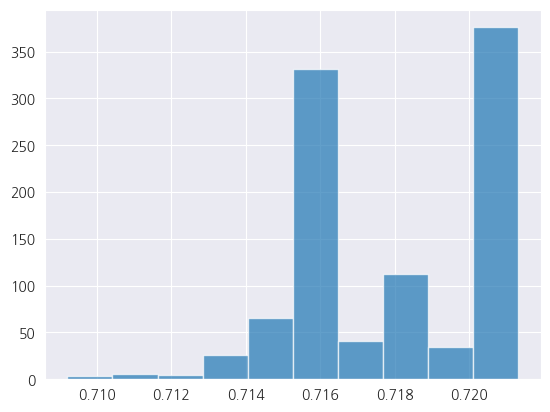

In [103]:
plt.hist(t_55, alpha=0.7)

In [ ]:
plt.hist(t_55, alpha=0.7)

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val,study, optuna_auc